# Hücre 1 — Import + Path

In [1]:
import os, sys, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODELS_DIR = os.path.join(BASE_DIR, "models")
sys.path.insert(0, MODELS_DIR)

from relu import TinyCNN_ReLU_SE
from silu import TinyCNN_SiLU_SE

print("BASE_DIR  :", BASE_DIR)
print("MODELS_DIR:", MODELS_DIR)

BASE_DIR  : c:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\activation_functions\Core\SiLU(Swish)
MODELS_DIR: c:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\activation_functions\Core\SiLU(Swish)\models


# Hücre 2 — Seed + Device

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Hücre 3 — Dataset / DataLoader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 128
NUM_CLASSES = 10

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_set  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(test_loader)

Files already downloaded and verified
Files already downloaded and verified


(391, 79)

# Hücre 4 — Train / Eval fonksiyonları

In [ ]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct = 0, 0
    loss_sum = 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum / total, correct / total


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_sum = 0.0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        total += x.size(0)
    return loss_sum / total

# Hücre 5 — Modelleri oluştur + aynı başlangıç ağırlığı

In [5]:
EPOCHS = 15
LR = 1e-3

set_seed(42)

relu_model = TinyCNN_ReLU_SE(num_classes=NUM_CLASSES).to(device)
silu_model = TinyCNN_SiLU_SE(num_classes=NUM_CLASSES).to(device)

silu_model.load_state_dict(relu_model.state_dict(), strict=True)

opt_relu = optim.Adam(relu_model.parameters(), lr=LR)
opt_silu = optim.Adam(silu_model.parameters(), lr=LR)

print("Models ready.")

Models ready.


# Hücre 6 — Eğitim döngüsü + log

In [6]:
history = {
    "relu_train_loss": [], "relu_test_loss": [], "relu_test_acc": [],
    "silu_train_loss": [], "silu_test_loss": [], "silu_test_acc": [],
}

for epoch in range(1, EPOCHS + 1):
    tr_relu = train_one_epoch(relu_model, train_loader, opt_relu, device)
    teL_relu, teA_relu = evaluate(relu_model, test_loader, device)

    tr_silu = train_one_epoch(silu_model, train_loader, opt_silu, device)
    teL_silu, teA_silu = evaluate(silu_model, test_loader, device)

    history["relu_train_loss"].append(tr_relu)
    history["relu_test_loss"].append(teL_relu)
    history["relu_test_acc"].append(teA_relu)

    history["silu_train_loss"].append(tr_silu)
    history["silu_test_loss"].append(teL_silu)
    history["silu_test_acc"].append(teA_silu)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"ReLU: train_loss={tr_relu:.4f} test_loss={teL_relu:.4f} acc={teA_relu:.4f} | "
        f"SiLU: train_loss={tr_silu:.4f} test_loss={teL_silu:.4f} acc={teA_silu:.4f}"
    )

Epoch 01/15 | ReLU: train_loss=1.5786 test_loss=1.5211 acc=0.4631 | SiLU: train_loss=1.6059 test_loss=1.3911 acc=0.4729
Epoch 02/15 | ReLU: train_loss=1.1944 test_loss=1.0626 acc=0.6189 | SiLU: train_loss=1.2327 test_loss=1.3979 acc=0.5038
Epoch 03/15 | ReLU: train_loss=1.0191 test_loss=0.9610 acc=0.6556 | SiLU: train_loss=1.0430 test_loss=0.9982 acc=0.6506
Epoch 04/15 | ReLU: train_loss=0.8951 test_loss=0.8686 acc=0.6946 | SiLU: train_loss=0.9278 test_loss=0.9583 acc=0.6639
Epoch 05/15 | ReLU: train_loss=0.8095 test_loss=0.9208 acc=0.6874 | SiLU: train_loss=0.8303 test_loss=0.8932 acc=0.6959
Epoch 06/15 | ReLU: train_loss=0.7429 test_loss=0.7693 acc=0.7272 | SiLU: train_loss=0.7634 test_loss=0.7572 acc=0.7374
Epoch 07/15 | ReLU: train_loss=0.6889 test_loss=0.7771 acc=0.7319 | SiLU: train_loss=0.7066 test_loss=0.7222 acc=0.7477
Epoch 08/15 | ReLU: train_loss=0.6483 test_loss=0.6726 acc=0.7683 | SiLU: train_loss=0.6598 test_loss=0.6985 acc=0.7648
Epoch 09/15 | ReLU: train_loss=0.6115 te

# Hücre 7 — Grafik (Accuracy + Loss)

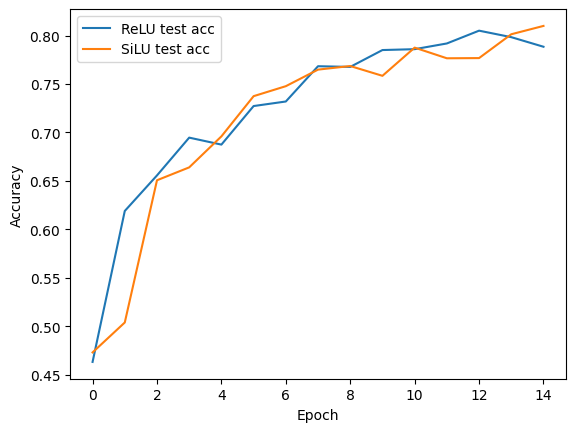

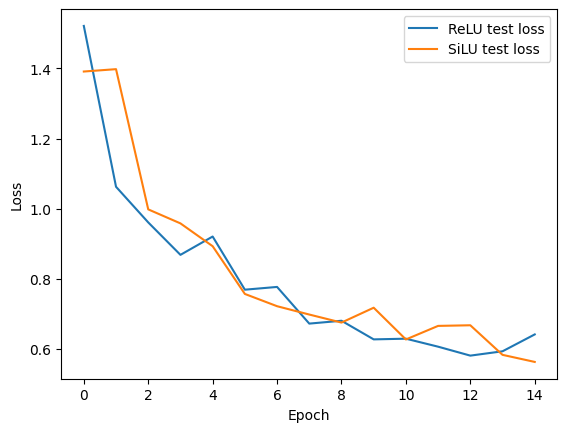

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["relu_test_acc"], label="ReLU test acc")
plt.plot(history["silu_test_acc"], label="SiLU test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["relu_test_loss"], label="ReLU test loss")
plt.plot(history["silu_test_loss"], label="SiLU test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Hücre 8 — Final özet

In [8]:
print("Final (last epoch):")
print(f"ReLU: acc={history['relu_test_acc'][-1]:.4f}, loss={history['relu_test_loss'][-1]:.4f}")
print(f"SiLU: acc={history['silu_test_acc'][-1]:.4f}, loss={history['silu_test_loss'][-1]:.4f}")

Final (last epoch):
ReLU: acc=0.7884, loss=0.6418
SiLU: acc=0.8099, loss=0.5634


## Sonuç ve Yorum (ReLU-SE vs SiLU-SE) — 15 Epoch

Bu deneyde iki model **aynı mimari (Residual + SE attention)**, **aynı veri seti**, **aynı optimizer**, **aynı seed** ve **aynı epoch (15)** ile eğitilmiştir.  
Tek fark backbone aktivasyonudur: **ReLU** vs **SiLU**.


### Final Performans (Epoch 15)

- **ReLU**
  - Train Loss: 0.4750
  - Test Loss: **0.6418**
  - Accuracy: **0.7884**

- **SiLU**
  - Train Loss: 0.4718
  - Test Loss: **0.5634**
  - Accuracy: **0.8099**

**Sonuç:** Bu koşuda **SiLU daha iyi genellemiş** (daha düşük test loss + daha yüksek accuracy).

### Eğitim Dinamikleri (Neler oldu?)

- İlk epoch’larda iki model benzer ilerliyor, hatta bazı noktalarda ReLU öne geçiyor.
- Orta epoch’larda (8–13 arası) ReLU zaman zaman daha yüksek accuracy yakalıyor.
- **Son kısımda (özellikle Epoch 14–15)** SiLU belirgin şekilde toparlıyor ve **finalde net üstünlük** sağlıyor.

Bu, SiLU’nun **smooth** yapısı sayesinde bazı durumlarda optimizasyonu daha stabil hale getirip
daha iyi bir minimuma yerleşebilmesiyle uyumludur.


### Kritik Gözlem (Overfitting işareti)

- ReLU tarafında Epoch 13’te accuracy 0.8050 iken,
  Epoch 15’te accuracy 0.7884’e düşüyor ve test loss yükseliyor (**0.6418**).
  Bu, **hafif overfitting / genelleme dalgalanması** işareti olabilir.
- SiLU tarafında ise Epoch 15’te test loss düşmeye devam etmiş (**0.5634**) ve accuracy artmış (**0.8099**).
  Bu, **daha iyi genelleme** işaretidir.



### Net Sonuç

Bu deneyde **SiLU**, ReLU’ya göre daha iyi performans vermiştir.  
Özellikle final epoch’ta:
- **+0.0215** mutlak accuracy avantajı (0.8099 vs 0.7884)
- **daha düşük test loss** (0.5634 vs 0.6418)

> Not: Daha sağlam karar için farklı seed’lerle birkaç tekrar koşusu (örn. 3 seed) önerilir.


## Eğitim Sonuçları (15 Epoch)  
**ReLU-SE vs SiLU-SE — Aynı mimari, aynı attention, aynı veri seti**

| Epoch | Model | Train Loss | Test Loss | Accuracy |
|------:|:------|-----------:|----------:|---------:|
| 1 | ReLU | 1.5786 | 1.5211 | 0.4631 |
| 1 | SiLU | 1.6059 | 1.3911 | 0.4729 |
| 2 | ReLU | 1.1944 | 1.0626 | 0.6189 |
| 2 | SiLU | 1.2327 | 1.3979 | 0.5038 |
| 3 | ReLU | 1.0191 | 0.9610 | 0.6556 |
| 3 | SiLU | 1.0430 | 0.9982 | 0.6506 |
| 4 | ReLU | 0.8951 | 0.8686 | 0.6946 |
| 4 | SiLU | 0.9278 | 0.9583 | 0.6639 |
| 5 | ReLU | 0.8095 | 0.9208 | 0.6874 |
| 5 | SiLU | 0.8303 | 0.8932 | 0.6959 |
| 6 | ReLU | 0.7429 | 0.7693 | 0.7272 |
| 6 | SiLU | 0.7634 | 0.7572 | 0.7374 |
| 7 | ReLU | 0.6889 | 0.7771 | 0.7319 |
| 7 | SiLU | 0.7066 | 0.7222 | 0.7477 |
| 8 | ReLU | 0.6483 | 0.6726 | 0.7683 |
| 8 | SiLU | 0.6598 | 0.6985 | 0.7648 |
| 9 | ReLU | 0.6115 | 0.6808 | 0.7676 |
| 9 | SiLU | 0.6229 | 0.6755 | 0.7685 |
|10 | ReLU | 0.5804 | 0.6277 | 0.7850 |
|10 | SiLU | 0.5888 | 0.7179 | 0.7584 |
|11 | ReLU | 0.5580 | 0.6296 | 0.7859 |
|11 | SiLU | 0.5631 | 0.6274 | 0.7875 |
|12 | ReLU | 0.5294 | 0.6068 | 0.7918 |
|12 | SiLU | 0.5394 | 0.6661 | 0.7765 |
|13 | ReLU | 0.5109 | 0.5813 | 0.8050 |
|13 | SiLU | 0.5130 | 0.6679 | 0.7767 |
|14 | ReLU | 0.4944 | 0.5937 | 0.7983 |
|14 | SiLU | 0.4905 | 0.5836 | 0.8013 |
|15 | ReLU | 0.4750 | 0.6418 | 0.7884 |
|15 | SiLU | 0.4718 | 0.5634 | 0.8099 |


## Kısa Sonuç

Bu deneyde, **aynı mimari ve eğitim koşulları** altında  
**SiLU**, ReLU’ya kıyasla **daha yüksek doğruluk** ve **daha düşük test loss** elde etmiştir.  
Dolayısıyla bu mimari için **SiLU tercih edilmelidir**.
